# AI허브 한국 이미지(음식)

In [1]:
from PIL import Image
import os
import shutil
import random
random.seed = 42
root_dir = '../../'
base_dir = os.path.join(root_dir, 'krfood')
split_dir = {split_name:os.path.join(base_dir,split_name)
                for split_name in ['train','valid','test']}

## 데이터 전처리

### 대분류와 소분류로 나눠져있던 폴더 구조에서 대분류 제거

In [2]:
image_dir = os.path.join(base_dir, 'images')

for cat_name in os.listdir(image_dir):
    if cat_name.__contains__('.'):
        continue

    cat_dir = os.path.join(image_dir, cat_name)
    for food_name in os.listdir(cat_dir):
        if food_name.startswith('.'):
            continue

        src = os.path.join(cat_dir, food_name)
        dst = os.path.join(image_dir, food_name)

        if cat_name == food_name:
            dst = os.path.join(base_dir, food_name)
        shutil.move(src, dst)
    shutil.rmtree(cat_dir)

### 소분류 목록을 data.yaml 파일에 저장하고 폴더명을 숫자로 변환

In [3]:
food_list = sorted(os.listdir(image_dir))
food_list.remove('.DS_Store')

with open(os.path.join(base_dir, 'data.yaml'), mode='w') as f:
    f.write('nc: ' + str(len(food_list)))
    f.write('\n')
    f.write('names: ' + str(food_list))

for index, food_name in enumerate(food_list):
    food_dir = os.path.join(image_dir, food_name)
    index_dir = os.path.join(image_dir, str(index))
    os.rename(food_dir, index_dir)

### .jpg 이외의 이미지 파일 확장자 변경

In [4]:
for food_name in os.listdir(image_dir):
    if food_name.startswith('.'):
        continue

    food_image_dir = os.path.join(image_dir, food_name)
    food_image_list = os.listdir(food_image_dir)

    for food_image in food_image_list:
        food_image_name = food_image.split('.')
        if food_image_name[1] in ['JPG','jpeg','png','PNG','gif','GIF','bmp','BMP']:
            src = os.path.join(food_image_dir, food_image)
            dst = os.path.join(food_image_dir, food_image_name[0]+'.jpg')
            os.rename(src, dst)

### 모든 폴더에서 org_url.csv 파일 삭제

In [5]:
for food_name in os.listdir(image_dir):
    if food_name.startswith('.'):
        continue

    food_image_dir = os.path.join(image_dir, food_name)
    os.remove(os.path.join(food_image_dir, 'org_url.csv'))

## Label Split

In [2]:
image_dir = os.path.join(base_dir, 'images')
label_dir = os.path.join(base_dir, 'labels')

if os.path.exists(label_dir):
    shutil.rmtree(label_dir)
os.mkdir(label_dir)

### x1,y1,x2,y2 좌표를 Yolo 형식의 좌표로 변경하는 함수

In [3]:
def convert_yolo_bbox(img_size, box):
    dw = 1./img_size[0]
    dh = 1./img_size[1]
    x = (int(box[0]) + int(box[2]))/2.0
    y = (int(box[1]) + int(box[3]))/2.0
    w = abs(int(box[2]) - int(box[0]))
    h = abs(int(box[3]) - int(box[1]))
    x, w, y, h = x*dw, w*dw, y*dh, h*dh
    # Yolo bbox x, y, width, height
    return (x,y,w,h)

### 라벨 파일을 이미지 파일과 대응되는 각각의 텍스트 파일로 분리

In [4]:
for food_name in os.listdir(image_dir):
    if food_name.startswith('.'):
        continue

    food_image_dir = os.path.join(image_dir, food_name)
    food_label_dir = os.path.join(label_dir, food_name)
    os.mkdir(food_label_dir)

    # 라벨 파일을 읽어와서 각각의 이미지에 대한 bounding box 정보를 딕셔너리로 생성
    label_file = os.path.join(food_image_dir, 'crop_area.properties')
    label_dict = dict()
    with open(label_file, 'r') as f:
        for line in f.readlines():
            food_image_name, crop_area = line.replace('\n','').split('=')
            label_dict[food_image_name] = crop_area

    # 이미지마다 하나의 라벨 파일을 생성
    food_image_list = os.listdir(food_image_dir)
    for food_image in food_image_list:
        if food_image.startswith('.'):
            continue

        food_image_file = os.path.join(food_image_dir, food_image)
        food_image_name = food_image.split('.')[0]
        if food_image_name in label_dict.keys():
            img = Image.open(food_image_file)
            crop_area = label_dict[food_image_name].split(',')

            # bounding box 정보가 올바르게 적혀있지 않은 경우 예외처리
            if len(crop_area) < 4:
                crop_area = [0,0] + list(map(int,crop_area[1:]))
            elif len(crop_area) > 4:
                crop_area[3] = crop_area[3].split()[0]
                crop_area = list(map(int,crop_area[:4]))
            else:
                crop_area = list(map(int,crop_area))
            yolo_bbox = convert_yolo_bbox(img.size, crop_area)

            food_label_file = os.path.join(food_label_dir, food_image_name+'.txt')
            with open(food_label_file, mode='w') as f:
                f.write(f"{food_name} {' '.join(map(str,yolo_bbox))}\n")

### 라벨 파일이 붙어있지 않은 이미지 파일 삭제

In [5]:
for food_name in os.listdir(image_dir):
    if food_name.startswith('.'):
        continue

    food_image_dir = os.path.join(image_dir, food_name)
    food_label_dir = os.path.join(label_dir, food_name)
    food_image_list = os.listdir(food_image_dir)

    for food_image in food_image_list:
        if food_image.startswith('.'):
            continue

        food_image_name = food_image.split('.')[0]
        food_image_file = os.path.join(food_image_dir, food_image)
        food_label_file = os.path.join(food_label_dir, food_image_name+'.txt')
        if not os.path.exists(food_label_file):
            os.remove(food_image_file)

### 이미지 파일과 라벨 파일의 수가 일치하는지 검증

In [ ]:
for food_name in sorted(os.listdir(image_dir)):
    if food_name.startswith('.'):
        continue

    food_image_dir = os.path.join(image_dir, food_name)
    food_label_dir = os.path.join(label_dir, food_name)
    print(food_name, len(food_image_dir)==len(food_label_dir))

### 이미지에 bounding box 그리기

In [7]:
os.path.join(base_dir, 'images/128/Img_132_0611.jpg')
img = Image.open(os.path.join(base_dir, 'images/128/Img_132_0611.jpg'))
draw = ImageDraw.Draw(img)
draw.rectangle((0,87,500,394), outline=(0,255,0), width=3)
img.show()

## Train/Test Split

In [2]:
image_dir = os.path.join(base_dir, 'images')
label_dir = os.path.join(base_dir, 'labels')
base_dir = os.path.join(base_dir, 'data')
split_dir = {split_name:os.path.join(base_dir,split_name)
                for split_name in ['train','valid','test']}

split_image_dir = {split_name:os.path.join(each_dir,'images')
                    for split_name,each_dir in split_dir.items()}
split_label_dir = {split_name:os.path.join(each_dir,'labels')
                    for split_name,each_dir in split_dir.items()}

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.mkdir(base_dir)

for each_dir in split_dir.values():
    os.mkdir(each_dir)
for each_dir in split_image_dir.values():
    os.mkdir(each_dir)
for each_dir in split_label_dir.values():
    os.mkdir(each_dir)

In [3]:
for food_name in os.listdir(image_dir):
    if food_name.startswith('.'):
        continue

    food_file_list = os.listdir(os.path.join(image_dir, food_name))

    for origin_dir, each_split, ftype in zip([image_dir,label_dir],[split_image_dir,split_label_dir],['.jpg','.txt']):
        food_dir = os.path.join(origin_dir, food_name)
        split_food = {split_name:os.path.join(each_dir,food_name)
                        for split_name,each_dir in each_split.items()}

        for each_food in split_food.values():
            os.mkdir(each_food)

        for index, food_file in enumerate(food_file_list):
            if food_file.startswith('.'):
                continue

            food_file = food_file.split('.')[0] + ftype
            src = os.path.join(food_dir, food_file)
            if index <= len(food_file_list)*0.8:
                dst = os.path.join(split_food['train'], food_file)
            elif index <= len(food_file_list)*0.9:
                dst = os.path.join(split_food['valid'], food_file)
            else:
                dst = os.path.join(split_food['test'], food_file)
            shutil.copyfile(src, dst)

## EDA

In [4]:
import random
from matplotlib import pyplot as plt

# 클래스의 이미지 랜덤하게 1개 보여주는 함수
def show_random_image_in_train_set(food_name):
    image_dir = os.path.join(split_image_dir['train'], food_name)
    img = random.choice(os.listdir(image_dir))
    plt.imshow(plt.imread(os.path.join(image_dir, img)))

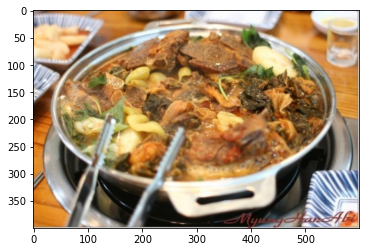

In [7]:
show_random_image_in_train_set('10')